In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [3]:
channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
channel_PALM_drift = "SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift

In [25]:
def LoadData(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = pulse_ids%4 == 0        #This is for 25 Hz
        reprate_laser = pulse_ids%2 == 0      #This is for 50 Hz
        
        LaserDiode_pumped = BS_file[channel_LaserDiode][reprate_FEL]
        LaserDiode_unpumped = BS_file[channel_LaserDiode][reprate_laser]
        Izero_pump = BS_file[channel_Izero][reprate_FEL]
        Izero_unpumped = BS_file[channel_Izero][reprate_laser]
        PIPS = BS_file[channel_PIPS_trans][reprate_FEL]
        LaserRefDiode = BS_file[channel_Laser_refDiode][reprate_laser]
        Delay = BS_file[channel_delay][reprate_laser]
        
    return LaserDiode_pumped, LaserDiode_unpumped, Izero_pump, Izero_unpumped, PIPS, LaserRefDiode, Delay

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [26]:
DIR = "/sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/"
DIR_json = "/sf/alvra/data/p17569/res/scan_info/"

!ls -lah -rt /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.1G
-rw-r--r--.   1 root  p17569  51M Dec 15 15:05 YAG_0.1_jet_LAMcheck_040_step0000.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:05 YAG_0.1_jet_LAMcheck_040_step0001.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:06 YAG_0.1_jet_LAMcheck_040_step0002.h5
-rw-r--r--.   1 root  p17569  52M Dec 15 15:07 YAG_0.1_jet_LAMcheck_040_step0003.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:08 YAG_0.1_jet_LAMcheck_040_step0004.h5
-rw-r--r--.   1 root  p17569  53M Dec 15 15:08 YAG_0.1_jet_LAMcheck_040_step0005.h5
-rw-r--r--.   1 root  p17569  52M Dec 15 15:09 YAG_0.1_jet_LAMcheck_040_step0006.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:10 YAG_0.1_jet_LAMcheck_040_step0007.h5
-rw-r--r--.   1 root  p17569  52M Dec 15 15:11 YAG_0.1_jet_LAMcheck_040_step0008.h5
-rw-r--r--.   1 root  p17569  52M Dec 15 15:11 YAG_0.1_jet_LAMcheck_040_step0009.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:12 YAG_0.1_jet_LAMcheck_040_step0010.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:13 YAG_0.1_jet_LAMche

In [27]:
fileName = "YAG_0.1_jet_LAMcheck_040_step0000.h5"

BS_file = h5py.File(DIR + fileName)

LaserDiode = BS_file[channel_LaserDiode]  
Delay = BS_file[channel_delay]
#LaserRefDiode = BS_file[channel_Laser_refDiode] 
#pulse_ids = BS_file[channel_pulse_ids]

#LAM_internalStage = BS_file[channel_LAM_delaystage]
#LAM_stepperStage = BS_file[channel_LAM_stepper]
#PALM_eTOF = BS_file[channel_PALM_eTOF]
#PALM_drift = BS_file[channel_PALM_drift]
#print (pulse_ids[0])

In [40]:
scan_name ="YAG_0.1_jet_LAMcheck_040"

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Laser_pumped = []
err_laser_pumped = []
Laser_unpumped = []
err_laser_unpumped = [] 
Izero_pumped = []
err_Izero_pumped = []
Izero_unpumped = []
err_Izero_unpumped = []
PIPS = []
Laser_ref = []
Delay_mm = []

for i in range(0,numFiles):
    print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
    (Laser_pumped_loop,Laser_unpumped_loop,Izero_pumped_loop,Izero_unpumped_loop,PIPS_loop,Laser_ref_loop,delay_loop) = LoadData(str(data['scan_files'][i][0]))
    Laser_pumped.append(Laser_pumped_loop.mean())
    err_laser_pumped.append(Laser_pumped_loop.std()/np.sqrt(Laser_pumped_loop.size))
    Laser_unpumped.append(Laser_unpumped_loop.mean())
    err_laser_unpumped.append(Laser_unpumped_loop.std()/np.sqrt(Laser_unpumped_loop.size))
    Izero_pumped.append(Izero_pumped_loop.mean())
    err_Izero_pumped.append(Izero_pumped_loop.std()/np.sqrt(Izero_pumped_loop.size))
    Izero_unpumped.append(Izero_unpumped_loop.mean())
    err_Izero_unpumped.append(Izero_unpumped_loop.std()/np.sqrt(Izero_unpumped_loop.size))
    PIPS.append(PIPS_loop.mean())
    Laser_ref.append(Laser_ref_loop.mean())
    Delay_mm.append(delay_loop.mean())
    
Laser_pumped = np.asarray(Laser_pumped)
err_laser_pumped = np.asarray(err_laser_pumped)
Laser_unpumped = np.asarray(Laser_unpumped)
err_laser_unpumped = np.asarray(err_laser_unpumped)
Izero_pumped = np.asarray(Izero_pumped)
err_Izero_pumped = np.asarray(err_Izero_pumped)
Izero_unpumped = np.asarray(Izero_unpumped)
err_Izero_unpumped = np.asarray(err_Izero_unpumped)

/sf/alvra/data/p17569/res/scan_info/YAG_0.1_jet_LAMcheck_040_scan_info.json
Processing 21 files
step 1 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0000.h5
step 2 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0001.h5
step 3 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0002.h5
step 4 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0003.h5
step 5 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0004.h5
step 6 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0005.h5
step 7 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0006.h5
step 8 of 21 : Processing /sf/alvra/

In [41]:
laser_pumped_norm = Laser_pumped / Izero_pumped
err_laser_pumped_norm = err_laser_pumped / Izero_pumped
laser_unpumped_norm = Laser_unpumped / Izero_unpumped
err_laser_unpumped_norm = err_laser_unpumped / Izero_unpumped

laser_diff = -np.log10(laser_pumped_norm / laser_unpumped_norm) 
#Delay_ps = (Delay_x - 148.496)*3.333   # factor of 2 in delay due to the delay stage is considered below.
# here to add the time zero value

<IPython.core.display.Javascript object>


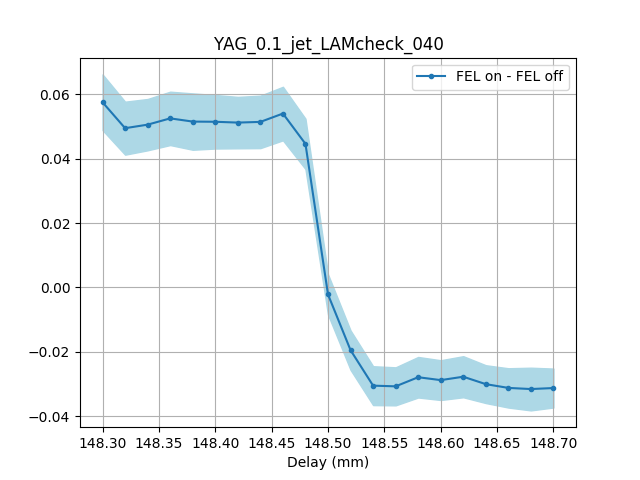

In [42]:
plt.figure()
plt.plot(Delay_mm, laser_diff, label="FEL on - FEL off",marker='.')

low_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) - (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
high_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) + (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')
plt.title("YAG_0.1_jet_LAMcheck_040")
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig(savedir + 'LAMcheck_026')